## Boilerplate

In [1]:
import sys
import subprocess
import os
import json
from pathlib import Path

if 'google.colab' in sys.modules:
    print("Running on Colab")

    subprocess.run([
        'git', 'clone', 'https://github.com/walligot/don_thesis.git'
    ])

    os.chdir('/content/don_thesis')
    #%pip install git+https://github.com/mitchellostrow/DSA.git
    %pip install git+https://github.com/Melina-Jingting/foundational_ssm.git

    from google.colab import drive
    drive.mount('/content/drive')

    os.environ['HOME'] = '/content/drive/MyDrive/Thesis'
    ROOT_PATH = '/content/don_thesis'
    os.environ['ROOT_PATH'] = ROOT_PATH

    wandb_config_path = '/content/drive/MyDrive/Colab/wandb.config.json'

else:
    #%pip install git+https://github.com/mitchellostrow/DSA.git

    current_path = Path().resolve()
    ROOT_PATH = None
    for parent in [current_path] + list(current_path.parents):
        if "don_thesis" in parent.name.lower():
            ROOT_PATH = parent
            os.environ['ROOT_PATH'] = str(ROOT_PATH)
            break

    if not ROOT_PATH:
        raise FileNotFoundError("Directory with name 'don_thesis' not found.")

    print("Running locally or elsewhere")
    wandb_config_path = os.path.join(os.environ['ROOT_PATH'], 'config', 'wandb.config.json')

# Set WANDB_CONFIG_PATH
os.environ['WANDB_CONFIG_PATH'] = wandb_config_path

# Load API key from JSON
with open(wandb_config_path) as f:
    config = json.load(f)
    os.environ['WANDB_API_KEY'] = config['WANDB_API_KEY']

%pip install pynwb
%pip install equinox
#%pip install equinox==0.12.2 jax==0.7.0 jaxlib==0.7.0

sys.path.append('/content/don_thesis/src')
print(f"Root path: {ROOT_PATH}")
print(f"WANDB config path: {wandb_config_path}")


Running on Colab
  Cloning https://github.com/Melina-Jingting/foundational_ssm.git to /tmp/pip-req-build-8y4mvr4i
  Running command git clone --filter=blob:none --quiet https://github.com/Melina-Jingting/foundational_ssm.git /tmp/pip-req-build-8y4mvr4i
  Resolved https://github.com/Melina-Jingting/foundational_ssm.git to commit 0946f85db8cb835434ac12f50e22c187e8824699
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
from omegaconf import OmegaConf
import yaml

DATA_ROOT = '/content/drive/MyDrive/Thesis/data/'

config_dict = [
    {
        'selection': [
            {
                'brainset': 'odoherty_sabes_nonhuman_2017',
                'sessions': ['indy_20170131_02']
            }
        ],
        'config': {
            'readout': {
                'readout_id': 'cursor_velocity_2d'
            }
        }
    }
]

cfg = OmegaConf.create(config_dict)

with open("activations.yaml", "w") as f:
    yaml.dump(config_dict, f, default_flow_style=False)

cfg_path = os.getcwd() + "/activations.yaml"

## Code Definitions

### Procrustes

In [ ]:
import numpy as np
from scipy.spatial import procrustes

def batched_procrustes_distance_old(A, B, normalize=True):
    # Ensure inputs are numpy arrays
    A = np.asarray(A)
    B = np.asarray(B)

    # Check dimensions and expand if needed
    if A.ndim == 2:
        A = A[None, ...]
    elif A.ndim != 3:
        raise ValueError("A must be 2D or 3D (batch x N x D)")

    if B.ndim == 2:
        B = B[None, ...]
    elif B.ndim != 3:
        raise ValueError("B must be 2D or 3D (batch x N x D)")

    # Check matching shapes
    if A.shape != B.shape:
        raise ValueError(f"Shape mismatch: A{A.shape} vs B{B.shape}")

    # Call procrustes_distance per batch (after squeezing)
    scores = [procrustes_distance(a_i.squeeze(), b_i.squeeze(), normalize=normalize)
              for a_i, b_i in zip(A, B)]

    return np.mean(scores)

import numpy as np
from sklearn.decomposition import PCA

def _pad_last_dim(X, target_dim):
    pad_width = target_dim - X.shape[2]
    if pad_width < 0:
        return X[..., :target_dim]
    return np.pad(X, ((0, 0), (0, 0), (0, pad_width)))

def _pad_to_match_dims(A, B):
    target_dim = max(A.shape[2], B.shape[2])
    return _pad_last_dim(A, target_dim), _pad_last_dim(B, target_dim)

def _shuffle_timesteps(X, inds):
    return np.concatenate([x[inds] for x in X], axis=0)

def _shuffle_trials(X, inds):
    return X[inds].reshape(-1, X.shape[2])

def _shuffle_all(X, inds):
    X_flat = X.reshape(-1, X.shape[2])
    return X_flat[inds]

def _prepare_concat_single(X, mode, shuffled_inds):
    if mode == 'shuffle_timesteps':
        return _shuffle_timesteps(X, shuffled_inds)
    elif mode == 'shuffle_trials':
        return _shuffle_trials(X, shuffled_inds)
    elif mode == 'shuffle_all':
        return _shuffle_all(X, shuffled_inds)
    elif mode == 'concat':
        return X.reshape(-1, X.shape[2])
    else:
        raise ValueError(f"Unknown mode: {mode}")

def _apply_pca_shared(A_concat, B_concat, pca_dim):
    A_pca = PCA(n_components=pca_dim).fit_transform(A_concat)
    B_pca = PCA(n_components=pca_dim).fit_transform(B_concat)
    return A_pca, B_pca

def _apply_pca_trialwise(A, B, pca_dim):
    A_pca = np.stack([PCA(n_components=pca_dim).fit_transform(a) for a in A])
    B_pca = np.stack([PCA(n_components=pca_dim).fit_transform(b) for b in B])
    return A_pca, B_pca

def batched_procrustes_distance(X, Y, normalize=True, mode='concat', pca_dim=None, shuffled_inds=None):
    X_list = X if isinstance(X, list) else [X]
    Y_list = Y if isinstance(Y, list) else [Y]

    # Ensure all inputs are 3D
    X_list = [x[None, ...] if x.ndim == 2 else x for x in X_list]
    Y_list = [y[None, ...] if y.ndim == 2 else y for y in Y_list]

    # Check n_trials and n_timesteps match
    shape_ref = X_list[0].shape[:2] if X_list else Y_list[0].shape[:2]
    for tensor in X_list + Y_list:
        if tensor.shape[:2] != shape_ref:
            raise ValueError("Mismatch in n_trials or n_timesteps")

    # Decide whether PCA is needed
    all_dims = [x.shape[2] for x in X_list + Y_list]
    dims_match = all(d == all_dims[0] for d in all_dims)
    apply_pca = pca_dim is not None or not dims_match

    if apply_pca:
        if pca_dim is None:
            pca_dim = int(0.8 * min(all_dims))
            print(f"[pca] Auto PCA: projecting to {pca_dim} dims (hidden dims differ)")
        if pca_dim <= 0:
            raise ValueError("pca_dim must be positive")

    # Generate shuffle indices if needed
    if shuffled_inds is None and mode in {'shuffle_timesteps', 'shuffle_trials', 'shuffle_all'}:
        n_trials, n_timesteps = shape_ref
        if mode == 'shuffle_timesteps':
            shuffled_inds = np.random.permutation(n_timesteps)
        elif mode == 'shuffle_trials':
            shuffled_inds = np.random.permutation(n_trials)
        elif mode == 'shuffle_all':
            shuffled_inds = np.random.permutation(n_trials * n_timesteps)

    results = []
    for A in X_list:
        row = []
        for B in Y_list:
            # Pad if PCA required
            #A_pad, B_pad = (A, B) if not apply_pca else _pad_to_match_dims(A, B)
            A_pad, B_pad = (A, B)

            if mode == 'mean':
                if apply_pca:
                    A_proc, B_proc = _apply_pca_trialwise(A_pad, B_pad, pca_dim)
                else:
                    A_proc, B_proc = A_pad, B_pad

                score = np.mean([
                    #procrustes_distance(a, b, normalize=normalize)
                    procrustes(a, b)[2]
                    for a, b in zip(A_proc, B_proc)
                ])
                del A_proc, B_proc
            else:
                A_concat = _prepare_concat_single(A_pad, mode, shuffled_inds)
                B_concat = _prepare_concat_single(B_pad, mode, shuffled_inds)

                if apply_pca:
                    A_proc, B_proc = _apply_pca_shared(A_concat, B_concat, pca_dim)
                else:
                    A_proc, B_proc = A_concat, B_concat

                #score = procrustes_distance(A_proc, B_proc, normalize=normalize)
                _, _, score = procrustes(A_proc, B_proc)
                del A_concat, B_concat, A_proc, B_proc

            del A_pad, B_pad
            row.append(score)
        results.append(row)

    return np.array(results)

def align_trajectories(hidden_states):
    """
    Aligns the trajectories within each numpy array in hidden_states to the first trajectory using Procrustes analysis.

    Args:
    - hidden_states (list of np.ndarray): List of numpy arrays where each array has shape (n_timesteps, n_hidden_units).

    Returns:
    - aligned_trajectories (list of np.ndarray): List of numpy arrays containing the aligned trajectories for each model/condition.
    """
    aligned_trajectories = []  # To store the aligned arrays

    # Step 1: Extract the first trajectory's data (baseline for alignment)
    baseline_trajectory = hidden_states[0]  # Shape: (n_timesteps, n_hidden_units)

    # Step 2: Iterate over each array in the list (representing different models/conditions)
    for trajectory in hidden_states:
        # Apply Procrustes analysis to align each trajectory to the baseline
        m1, m2, disparity = procrustes(baseline_trajectory, trajectory)

        # Append the aligned trajectory (m1 is the aligned trajectory) to the list
        aligned_trajectories.append(m2)  # m1 is the aligned trajectory

    return aligned_trajectories


### Decoding

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm


def split_by_trials(hs, beh, test_size=0.2, random_state=0, shuffle=True):
    """
    Split hidden states and behaviour by trials, then flatten time
    so that outputs match the shape expected by scikit-learn decoders.

    Parameters
    ----------
    hs : array, shape (n_trials, n_timesteps, n_units)
    beh : array, shape (n_trials, n_timesteps, n_targets)
    test_size : float or int
    random_state : int
    shuffle : bool

    Returns
    -------
    Xtr : (n_train_trials * n_timesteps, n_units)
    Xte : (n_test_trials * n_timesteps, n_units)
    ytr : (n_train_trials * n_timesteps, n_targets)
    yte : (n_test_trials * n_timesteps, n_targets)
    """
    n_trials = hs.shape[0]
    idx = np.arange(n_trials)
    tr_idx, te_idx = train_test_split(
        idx, test_size=test_size, random_state=random_state, shuffle=shuffle
    )

    hs_tr, hs_te = hs[tr_idx], hs[te_idx]
    beh_tr, beh_te = beh[tr_idx], beh[te_idx]

    # flatten time
    Xtr = hs_tr.reshape(-1, hs.shape[-1])
    Xte = hs_te.reshape(-1, hs.shape[-1])
    ytr = beh_tr.reshape(-1, beh.shape[-1])
    yte = beh_te.reshape(-1, beh.shape[-1])

    return Xtr, Xte, ytr, yte

def simple_linear_decoder(hidden_states, behaviour, test_size=0.2, alphas=[1e-3, 1e-2, 1e-1, 1], top_n=10, random_state=0):
    """
    Trains a linear decoder from hidden states to behaviour.
    Returns held-out R^2, weights, and indices of top N contributing features.

    Returns
    -------
    R2 : float, held-out R^2 score
    weights : np.array, decoder coefficients
    top_indices : np.array, indices of top N features (by abs value)
    """
    hs = np.array(hidden_states)
    beh = np.array(behaviour)
    N, T, H = hs.shape
    X = hs.reshape(-1, H)
    y = beh.reshape(-1, beh.shape[-1])
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=random_state)
    decoder = RidgeCV(alphas=alphas).fit(Xtr, ytr)
    R2 = decoder.score(Xte, yte)
    # For multi-output, sum abs value across outputs (axis=0 is targets, axis=1 is features)
    importance = np.abs(decoder.coef_).sum(axis=0)  # shape: (n_features,)
    top_indices = np.argsort(importance)[::-1][:top_n]
    return R2, decoder.coef_, top_indices

def simple_class_decoder(hidden_states, classes, test_size=0.2, alphas=[1e-3, 1e-2, 1e-1, 1], top_n=10, random_state=0):
    """
    Trains a linear decoder from hidden states to behaviour.
    Returns held-out R^2, weights, and indices of top N contributing features.

    Returns
    -------
    R2 : float, held-out R^2 score
    weights : np.array, decoder coefficients
    top_indices : np.array, indices of top N features (by abs value)
    """
    hs = np.array(hidden_states)
    beh = np.array(classes)
    N, T, H = hs.shape
    X = hs.reshape(-1, H)
    y = beh.reshape(-1, beh.shape[-1])
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=random_state)
    #decoder = RidgeCV(alphas=alphas).fit(Xtr, ytr)
    decoder = LogisticRegression(max_iter=1000, class_weight="balanced").fit(Xtr, ytr)
    R2 = decoder.score(Xte, yte)
    # For multi-output, sum abs value across outputs (axis=0 is targets, axis=1 is features)
    importance = np.abs(decoder.coef_).sum(axis=0)  # shape: (n_features,)
    top_indices = np.argsort(importance)[::-1][:top_n]
    return R2, decoder.coef_, top_indices


def evaluate_smoothing_vs_r2(hidden_states, behaviour, sigma_values=[0, 0.5, 1, 2, 5], title = "Smoothing vs Decoding"):
    r2_scores = []

    for sigma in tqdm(sigma_values, desc="Evaluating sigmas"):
        if sigma == 0:
            smoothed = hidden_states.copy()
        else:
            smoothed = gaussian_filter1d(hidden_states, sigma=sigma, axis=1)
        r2, _, _ = simple_linear_decoder(smoothed, behaviour)
        r2_scores.append(r2)

    #plt.plot(sigma_values, r2_scores, marker='o')
    #plt.xlabel('Smoothing Sigma')
    #plt.ylabel('Held-out R²')
    #plt.title(title)
    #plt.grid(True)
    #plt.show()
    return sigma_values, r2_scores

### Similarity Matrix Graph

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import re


def parse_model_metadata(labels):
    rows = []
    for label in labels:
        clean_label = re.sub(r'\s*\(Baseline\)', '', label)
        clean_label = re.sub(r'\s*\(latest\)', '', label)
        model_match = re.match(r'^(S4D \dBlock)', clean_label)
        model = model_match.group(1) if model_match else 'Unknown'
        if 'Concat' in clean_label:
            component = 'full'
        elif '1Block' in clean_label and 'ssm_block_0' in clean_label:
            component = 'full'
        elif 'ssm_block_0' in clean_label:
            component = 'ssm_block_0'
        elif 'ssm_block_1' in clean_label:
            component = 'ssm_block_1'
        else:
            component = 'unknown'
        rows.append({'label': label, 'clean_label': clean_label, 'model': model, 'component': component})
    return pd.DataFrame(rows)

import matplotlib.pyplot as plt
import seaborn as sns

def plot_procrustes_similarity(procrustes_scores, labels,
                                title='Procrustes Similarity',
                                save_path=None):
    """
    Plots a heatmap of procrustes similarity scores without any sorting or metadata parsing.

    Parameters
    ----------
    procrustes_scores : ndarray, shape (N, N)
        Square matrix of pairwise procrustes similarity scores.
    labels : list of str, length N
        Labels for the heatmap axes, used as-is.
    title : str
        Title for the heatmap.
    save_path : str or None
        If provided, save the figure to this path, replacing '*' with 'similarity'.
    """
    # Validate inputs
    N = len(labels)
    assert procrustes_scores.shape == (N, N), \
        "procrustes_scores must be a square matrix matching labels length"

    # Plot heatmap directly
    plt.figure(figsize=(10, 8))
    sns.heatmap(procrustes_scores,
                xticklabels=labels,
                yticklabels=labels,
                cmap='Greens',
                square=True)
    plt.title(title)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()

    # Save if path provided
    if save_path:
        out_path = save_path.replace('*', 'similarity')
        plt.savefig(out_path, dpi=300, bbox_inches='tight')

    plt.show()

### Plotly PCA Graphs

In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
import plotly.io as pio
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

pio.renderers.default = 'colab'  # For Google Colab

def compute_angle_bin(row, n_bins=8):
    pos = row['target_pos']
    idx = row['active_target']
    if isinstance(pos, np.ndarray) and pos.ndim == 2 and 0 <= idx < len(pos):
        x, y = pos[idx]
        angle = np.arctan2(y, x)
        bin_id = int(((angle + np.pi) / (2 * np.pi)) * n_bins) % n_bins
        bin_size = 360 / n_bins
        start = int(bin_id * bin_size)
        end = int(start + bin_size)
        return f"{start}–{end}"
    return np.nan

def plot_trajectories_plotly(hidden_states, title, trial_types=None,
                              pca_dim=2, smooth=False, sigma=1, downsample=None,
                              save_path=None, mean_traj=False, align_traj=False):
    hidden_np = hidden_states.cpu().numpy()
    n_traj = hidden_np.shape[0]

    if hidden_np.ndim != 3:
        raise ValueError("Expected 3D tensor for hidden_states")

    all_h_pca = []
    for i in range(n_traj):
        h = hidden_np[i]
        if smooth:
            h = gaussian_filter1d(h, sigma=sigma, axis=0)
        if downsample is not None:
            h = h[::downsample]
        all_h_pca.append(h)

    # Downsample trial_types if it's 2D and mismatched in time dimension
    if (downsample is not None and trial_types is not None and isinstance(trial_types, (list, np.ndarray))):
        trial_types = np.array(trial_types)
        if trial_types.ndim == 2 and trial_types.shape[1] != all_h_pca[0].shape[0]:
            trial_types = trial_types[:, ::downsample]

    # Fit global PCA
    h_concat = np.concatenate(all_h_pca, axis=0)
    pca = PCA(n_components=pca_dim)
    pca.fit(h_concat)
    #all_h_pca = [pca.transform(h) for h in all_h_pca]

    if mean_traj:
        trial_types = np.array(trial_types)
        unique_types = sorted(set(trial_types))
        min_len = min(h.shape[0] for h in all_h_pca)

        mean_trajs = [
            np.mean([hidden_np[i][:min_len] for i in range(len(trial_types)) if trial_types[i] == label], axis=0)
            for label in unique_types
        ]

        #print(mean_trajs[0][:2])

        if align_traj:
            mean_trajs = align_trajectories(mean_trajs)

        #print(mean_trajs[0][:2])
        #print(mean_trajs[-1].shape)
        #print(mean_trajs[-1][:10])

        all_h_pca = [pca.transform(h) for h in mean_trajs]
        #print(all_h_pca[-1][:10])
        trial_types = unique_types
        opacity = 1.0

    elif align_traj:
        trial_types = np.array(trial_types)
        unique_types = sorted(set(trial_types))
        min_len = min(h.shape[0] for h in all_h_pca)
        aligned = [
            np.array([hidden_np[i][:min_len] for i in range(len(trial_types)) if trial_types[i] == label][0])
            for label in unique_types
        ]
        aligned = align_trajectories(aligned)
        all_h_pca = [pca.transform(h) for h in aligned]
        trial_types = unique_types
        opacity = 1.0

    else:
        opacity = 0.3
        all_h_pca = [pca.transform(h) for h in all_h_pca]

    explained = np.sum(pca.explained_variance_ratio_[:pca_dim])
    print(f"PCA explained {explained * 100:.2f}% of variance")

    # Colour setup
    cmap = get_cmap('tab20')
    #cmap = get_cmap('Greens')
    colour_map = {}
    colours = []
    is_per_timestep = False

    if trial_types is not None:
        trial_types = np.array(trial_types)
        if trial_types.ndim == 2:
            is_per_timestep = True
            unique_types = sorted(set(trial_types.ravel()))
        else:
            unique_types = sorted(set(trial_types))

        colour_map = {tt: cmap(i % cmap.N) for i, tt in enumerate(unique_types)}

        if not is_per_timestep:
            colours = [
                f'rgba({int(r*255)},{int(g*255)},{int(b*255)},{a})'
                for tt in trial_types
                for r, g, b, a in [colour_map[tt]]
            ]

    fig = go.Figure()
    seen_labels = set()

    for idx, h_pca in enumerate(all_h_pca):
        if is_per_timestep:
            tt_series = trial_types[idx]
            colour_array = [colour_map[tt] for tt in tt_series]
            rgba_list = [
                f'rgba({int(r*255)},{int(g*255)},{int(b*255)},{a})'
                for r, g, b, a in colour_array
            ]

            marker_dict = dict(size=2, color=rgba_list)

            if pca_dim == 3:
                fig.add_trace(go.Scatter3d(
                    x=h_pca[:, 0], y=h_pca[:, 1], z=h_pca[:, 2],
                    mode='markers',
                    marker=marker_dict,
                    name=f"Traj {idx + 1}",
                    showlegend=False
                ))
            else:
                fig.add_trace(go.Scatter(
                    x=h_pca[:, 0], y=h_pca[:, 1],
                    mode='markers',
                    marker=marker_dict,
                    name=f"Traj {idx + 1}",
                    showlegend=False
                ))
        else:
            line_colour = colours[idx] if colours else None
            trace_label = str(trial_types[idx]) if trial_types is not None else f"Traj {idx + 1}"
            show_legend = trace_label not in seen_labels
            seen_labels.add(trace_label)

            line_opts = dict(width=2)
            if line_colour:
                line_opts["color"] = line_colour

            if pca_dim == 3:
                fig.add_trace(go.Scatter3d(
                    x=h_pca[:, 0], y=h_pca[:, 1], z=h_pca[:, 2],
                    mode='lines',
                    line=line_opts,
                    name=trace_label,
                    opacity=opacity,
                    showlegend=show_legend
                ))
            else:
                fig.add_trace(go.Scatter(
                    x=h_pca[:, 0], y=h_pca[:, 1],
                    mode='lines',
                    line=line_opts,
                    name=trace_label,
                    opacity=opacity,
                    showlegend=show_legend
                ))

    # Median trajectory
    min_len = min(len(h) for h in all_h_pca)
    stacked = np.array([h[:min_len] for h in all_h_pca])
    mean_line = np.mean(stacked, axis=0)
    if pca_dim == 3:
        fig.add_trace(go.Scatter3d(
            x=mean_line[:, 0], y=mean_line[:, 1], z=mean_line[:, 2],
            mode='lines',
            line=dict(color='black', width=4),
            #opacity=0,
            name='Mean Trajectory'
        ))
    else:
        fig.add_trace(go.Scatter(
            x=mean_line[:, 0], y=mean_line[:, 1],
            mode='lines',
            line=dict(color='black', width=4),
            name='Mean Trajectory'
        ))

    # Legend setup
    if is_per_timestep:
        for label in unique_types:
            r, g, b, a = colour_map[label]
            rgba = f'rgba({int(r*255)},{int(g*255)},{int(b*255)},{a})'
            fig.add_trace(go.Scatter(
                x=[None], y=[None],
                mode='markers',
                marker=dict(size=6, color=rgba),
                name=str(label),
                showlegend=True
            ))
        fig.update_layout(showlegend=True, legend=dict(traceorder='normal'))

    elif trial_types is not None:
        labels_set = {trace.name for trace in fig.data}
        sorted_labels = sorted(labels_set, key=lambda x: int(x.split('–')[0]) if '–' in x else float('inf'))
        fig.data = tuple(sorted(fig.data, key=lambda t: sorted_labels.index(t.name) if t.name in sorted_labels else -1))
        fig.update_layout(showlegend=True, legend=dict(traceorder='normal'))

    else:
        fig.update_layout(showlegend=False)

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3' if pca_dim == 3 else ''
        ) if pca_dim == 3 else dict(
            xaxis_title='PC1',
            yaxis_title='PC2'
        ),
        width=800,
        height=600,
        margin=dict(l=0, r=200, t=50, b=0),
    )

    if save_path:
        fig.write_html(save_path)
        print(f"Saved to {save_path}")
    else:
        fig.show()


def plot_multiple_trajectories_plotly(hidden_states, overall_title,
                                      burn_in=0, labels=None,
                                      add_noise=False, pca_dim=2,
                                      smooth=False, sigma=1, downsample=None,
                                      trial_types=None, mean_traj = False, align_traj=False, save_path=None):
    n = len(hidden_states)
    titles = labels if labels else [f"Trajectory {i + 1}" for i in range(n)]

    print(overall_title)
    for i in range(n):
        this_save = None
        if save_path:
            base, ext = save_path.split("*")
            this_save = f"{base}{i}{ext}"
        plot_trajectories_plotly(hidden_states[i], titles[i],
                                 trial_types=trial_types,
                                 pca_dim=pca_dim,
                                 smooth=smooth,
                                 sigma=sigma,
                                 downsample=downsample,
                                 mean_traj=mean_traj,
                                 align_traj=align_traj,
                                 save_path=this_save)

### SSM Coupling Funcs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import schur, expm

def gelu(x):
    return 0.5 * x * (1 + np.erf(x / np.sqrt(2)))

def gelu_prime(x):
    Phi = 0.5 * (1 + np.erf(x / np.sqrt(2)))
    phi = np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
    return Phi + x * phi

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def discretize_zoh(Lambda, B_tilde, Delta):
    """
    Zero-Order Hold discretization of a diagonal continuous-time SSM.
    Lambda: complex eigenvalues, shape (P,)
    B_tilde: complex input matrix, shape (P, H)
    Delta: real step sizes, shape (P,)
    Returns A_bar (H,H) and B_bar if needed.
    """
    # For diagonal Lambda, expm(diag(Lambda*Delta)) = diag(exp(Lambda*Delta))
    A_bar = np.diag(np.exp(Lambda * Delta))
    B_bar = ((np.exp(Lambda * Delta) - 1) / Lambda)[:, None] * B_tilde
    return A_bar, B_bar

class TwoBlockSSMAnalyzer:
    def __init__(self, block0, block1):
        """
        Precompute discrete-time recurrence and weight composites for two S5Block-like objects.
        blockX.ssm attributes: Lambda_re, Lambda_im, B, C, D, log_step, step_rescale
        blockX.glu attributes: w1.weight, w1.bias, w2.weight, w2.bias
        """
        # --- Block 0 discretization ---
        # reconstruct complex Lambda and B
        Lambda0 = block0.ssm.Lambda_re + 1j * block0.ssm.Lambda_im  # (P,)
        B0_tilde = block0.ssm.B[..., 0] + 1j * block0.ssm.B[..., 1]  # (P, H)
        # compute step sizes
        Delta0 = block0.ssm.step_rescale * np.exp(block0.ssm.log_step[:, 0])  # (P,)
        # discretize
        A0_bar_diag, _ = discretize_zoh(Lambda0, B0_tilde, Delta0)
        # full A0_bar (H,H) for diagonal Lambda: A0_bar = V diag A0_bar_diag V^{-1}
        # but for convolutional SSM, A_bar acts element-wise per mode; approximate by diagonal
        self.A0 = A0_bar_diag.real  # shape (P,P) here; interpret as recurrence in modal basis

        # --- Block 1 discretization (same) ---
        Lambda1 = block1.ssm.Lambda_re + 1j * block1.ssm.Lambda_im
        B1_tilde = block1.ssm.B[..., 0] + 1j * block1.ssm.B[..., 1]
        Delta1 = block1.ssm.step_rescale * np.exp(block1.ssm.log_step[:, 0])
        A1_bar_diag, _ = discretize_zoh(Lambda1, B1_tilde, Delta1)
        self.A1 = A1_bar_diag.real

        # --- Extract read-out C0 and GLU weights ---
        C0_tilde = block0.ssm.C  # (H, P, 2)
        self.C0 = C0_tilde[..., 0]  # assume conj_sym mode, real part (H,P)

        self.W1 = block0.glu.w1.weight  # (H,H)
        self.b1 = block0.glu.w1.bias     # (H,)
        self.W2 = block0.glu.w2.weight  # (H,H)
        self.b2 = block0.glu.w2.bias     # (H,)

        # Precompute composites: W @ C0
        self.M1 = self.W1.dot(self.C0)   # (H,P)
        self.M2 = self.W2.dot(self.C0)   # (H,P)

    def compute_J(self, x_ssm):
        """
        Given pre-GELU activation x_ssm (H,), compute Jacobian J (H x P).
        """
        g_gelu = gelu_prime(x_ssm)               # (H,)
        x_act = gelu(x_ssm)                      # (H,)
        g1 = self.W1.dot(x_act) + self.b1        # (H,)
        g2 = self.W2.dot(x_act) + self.b2        # (H,)
        s2 = sigmoid(g2)                         # (H,)
        s2p = s2 * (1 - s2)                      # (H,)

        # GLU Jacobian rows: s2_i * M1_i + g1_i*s2p_i * M2_i
        F = (s2[:, None] * self.M1) + ((g1 * s2p)[:, None] * self.M2)  # (H,P)

        # Final coupling: multiply each row by GELU gain
        J = F * g_gelu[:, None]
        return J

    def analyze_inputs(self, x_ssm_list):
        """
        For each x_ssm in list, compute J, its SVs, and Schur of augmented system.
        Returns list of dicts {'J','S','T'}.
        """
        results = []
        H = self.A0.shape[0]
        for x_ssm in x_ssm_list:
            J = self.compute_J(x_ssm)
            S = np.linalg.svd(J, compute_uv=False)

            # Build augmented A_aug = [[A0,0],[J,A1]]
            A_aug = np.zeros((H*2, H*2))
            A_aug[:H, :H] = self.A0
            A_aug[H:, H:] = self.A1
            A_aug[H:, :H] = J

            T, _ = schur(A_aug, output='real')
            results.append({'J': J, 'S': S, 'T': T})
        return results

    def plot_results(self, results):
        """
        Plot singular-value spectra and heatmap of Schur T for first input.
        """
        plt.figure(figsize=(6,4))
        for res in results:
            plt.plot(res['S'], alpha=0.6)
        plt.title('Singular Value Spectra')
        plt.xlabel('Index')
        plt.ylabel('σ_i')
        plt.show()

        plt.figure(figsize=(5,5))
        plt.imshow(results[0]['T'], aspect='auto', cmap='bwr')
        plt.colorbar()
        plt.title('Schur Form T (first)')
        plt.show()


## Load Data

### Load Model Checkpoints

In [2]:
import wandb
import equinox as eqx
import os

# Foundational SSM imports
from omegaconf import OmegaConf
import tempfile
from foundational_ssm.models import SSMDownstreamDecoder

import wandb
import equinox as eqx
import os

# Foundational SSM imports
from omegaconf import OmegaConf
import tempfile
from foundational_ssm.models import SSMDownstreamDecoder, SSMFoundationalDecoder
from foundational_ssm.utils import h5_to_dict
from foundational_ssm.transform import smooth_spikes
import jax
import jax.numpy as jnp
import numpy as np
from typing import Any, BinaryIO

def load_model_and_state_from_checkpoint_wandb_old(artifact_full_name, model_cls=SSMDownstreamDecoder):
    """Load model, optimizer state, epoch, and step from a checkpoint file."""
    api = wandb.Api()
    try:
        artifact = api.artifact(artifact_full_name, type="checkpoint")
    except Exception as e:
        raise FileNotFoundError(f"Could not find checkpoint artifact: {artifact_full_name}")

    run = artifact.logged_by()
    run_cfg = OmegaConf.create(run.config)
    model_cfg = OmegaConf.create(run_cfg.model)
    model_template, state_template = eqx.nn.make_with_state(model_cls)(
        **model_cfg,
    )

    with tempfile.TemporaryDirectory() as temp_dir:
        artifact.download(temp_dir)
        model = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "model.ckpt"), model_template)
        state = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "state.ckpt"), state_template)

    meta = artifact.metadata
    return model, state, meta

def default_deserialise_filter_spec(f: BinaryIO, x: Any) -> Any:
    """Default filter specification for deserialising saved data.

    **Arguments**

    -   `f`: file-like object
    -   `x`: The leaf for which the data needs to be loaded.

    **Returns**

    The new value for datatype `x`.

    !!! info

        This function can be extended to customise the deserialisation behaviour for
        leaves.

    !!! example

        Skipping loading of jax.Array.

        ```python
        import jax.numpy as jnp
        import equinox as eqx

        tree = (jnp.array([4,5,6]), [1,2,3])
        new_filter_spec = lambda f,x: (
            x if isinstance(x, jax.Array) else eqx.default_deserialise_filter_spec(f, x)
        )
        new_tree = eqx.tree_deserialise_leaves("some_filename.eqx", tree, filter_spec=new_filter_spec)
        ```
    """  # noqa: E501
    try:
        if isinstance(x, (jax.Array, jax.ShapeDtypeStruct)):
            return jnp.load(f)
        elif isinstance(x, np.ndarray):
            # Important to use `np` here to avoid promoting NumPy arrays to JAX.
            return np.load(f)
        elif eqx.is_array_like(x):
            # np.generic gets deserialised directly as an array, so convert back to a scalar
            # type here.
            # See also https://github.com/google/jax/issues/17858
            out = np.load(f)
            if isinstance(x, jax.dtypes.bfloat16):
                out = out.view(jax.dtypes.bfloat16)
            if np.size(out) == 1:
                return type(x)(out.item())
        else:
            return x
    except:
        print("Failed to load data for leaf with shape/ value:", x.shape if hasattr(x, 'shape') else x)
        return x

def load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMDownstreamDecoder, model_cfg=None):
    """Load model, optimizer state, epoch, and step from a checkpoint file."""
    api = wandb.Api()
    try:
        artifact = api.artifact(artifact_full_name, type="checkpoint")
    except Exception as e:
        raise FileNotFoundError(f"Could not find checkpoint artifact: {artifact_full_name}")

    if model_cfg is None:
        run = artifact.logged_by()
        run_cfg = OmegaConf.create(run.config)
        print(run_cfg)
        model_cfg = OmegaConf.create(run_cfg.model)

    model_template, state_template = eqx.nn.make_with_state(model_cls)(
        **model_cfg
    )

    with tempfile.TemporaryDirectory() as temp_dir:
        artifact.download(temp_dir)
        model = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "model.ckpt"), model_template, default_deserialise_filter_spec)
        state = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "state.ckpt"), state_template, default_deserialise_filter_spec)

    meta = artifact.metadata
    model = eqx.nn.inference_mode(model)
    return model, state, meta

# rtt task models
layer = "2"
pretrain_mode = "scratch"
train_mode = "all"
#alias = "latest" # can be latest/best/ epoch_{any value in range(0,1000,100)}
# epoch 0 now stores a fresh model.
artifact_full_name_trained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:best"
artifact_full_name_untrained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:epoch_0"
rtt_2block_model, trained_state, trained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_trained)
rtt_2block_untrained_model, untrained_state, untrained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_untrained)

layer = "4"
artifact_full_name_trained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:best"
artifact_full_name_untrained = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:epoch_0"
#rtt_4block_model, trained_state, trained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_trained)
#rtt_4block_untrained_model, untrained_state, untrained_meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name_untrained)

model = "l2"
#dataset = "similar_task"
#dataset = "reaching_normalized"
dataset = "reaching"
#alias = "best"
alias = "latest"

# Foundational Models
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_2block_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

alias = "epoch_0"
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_2block_untrained_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

model = "l4"
#alias = "best"
alias = "latest"
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_4block_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

alias = "epoch_0"
artifact_full_name = f"melinajingting-ucl/foundational_ssm_pretrain/{model}_{dataset}_checkpoint:{alias}"
foundational_4block_untrained_model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMFoundationalDecoder)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: davekk (davekk-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'training.from_scratch': True}

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2_no_context.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prep

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2_no_context.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prep

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.01, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 4, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l4.yaml', 'optimizer': {'lr': 0.001, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prepend_history

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.01, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 0, 'ssm_num_layers': 4, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l4.yaml', 'optimizer': {'lr': 0.001, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'TrialSampler', 'dataloader_args': {'batch_size': 512, 'num_workers': 4, 'persistent_workers': True}}, 'dataset_args': {'config': 'configs/dataset/reaching.yaml'}, 'train_loader': {'sampler': 'RandomVariableWindowSampler', 'sampler_args': {'drop_short': True, 'max_window_length': 5, 'min_window_length': 1}, 'dataloader_args': {'batch_size': 512, 'num_workers': 20, 'persistent_workers': True}}, 'sampling_rate': 200, 'prepend_history

wandb:   3 of 3 files downloaded.  


### Activation Data

In [3]:
FOUND_2BLOCK_KEYS = [
    #'neural_input_raw', 'neural_input',
    'post_encoder', 'post_encoder_raw',
    'ssm_x_0','ssm_y_0', 'ssm_post_glu_0',
    'ssm_x_1','ssm_y_1', 'ssm_post_glu_1',
]

FOUND_4BLOCK_KEYS = FOUND_2BLOCK_KEYS + [
    'ssm_x_2','ssm_y_2', 'ssm_post_glu_2',
    'ssm_x_3','ssm_y_3', 'ssm_post_glu_3',
]

F_2_TARGETS = ['targets'] + FOUND_2BLOCK_KEYS
F_4_TARGETS = ['targets'] + FOUND_4BLOCK_KEYS



In [8]:
!ls /content/don_thesis/src/neuralencoder

__init__.py  __pycache__


In [4]:
from neuralencoder.decoding import load_activation_dict, blend_and_normalise_np

#foundational_2block_data = load_activation_dict("/content/drive/MyDrive/Thesis/data/activations_f_2block_20250830_2.npz")
#foundational_4block_data = load_activation_dict("/content/drive/MyDrive/Thesis/data/activations_f_4block_20250830_2.npz")
foundational_2block_data = load_activation_dict("/content/drive/MyDrive/Thesis/data/activations_reaching_2block_20250910_1.npz")
#foundational_4block_data = load_activation_dict("/content/drive/MyDrive/Thesis/data/activations_reaching_4block_20250910_1.npz")
foundational_input_raw = load_activation_dict("/content/drive/MyDrive/Thesis/data/f_input_raw_20250910_1.npz")

foundational_2block_data = blend_and_normalise_np(foundational_2block_model, foundational_2block_data, foundational_input_raw, norm_keys=F_2_TARGETS)
#foundational_4block_data = blend_and_normalise_np(foundational_4block_model, foundational_4block_data, foundational_input_raw, norm_keys=F_4_TARGETS)

/content/don_thesis/src/neuralencoder/decoding.py:78: ComplexWarning:

Casting complex values to real discards the imaginary part



In [ ]:
rtt_2block_data = load_activation_dict_rtt("/content/drive/MyDrive/Thesis/data/activations_rtt_2block_20250831_2.npz")
rtt_4block_data = load_activation_dict_rtt("/content/drive/MyDrive/Thesis/data/activations_rtt_4block_20250831_2.npz")

rtt_2block_data = blend_and_normalise_np_rtt(rtt_2block_model, rtt_2block_data, norm_keys=F_2_TARGETS)
rtt_4block_data = blend_and_normalise_np_rtt(rtt_4block_model, rtt_4block_data, norm_keys=F_4_TARGETS)

/tmp/ipython-input-3839903541.py:96: ComplexWarning:

Casting complex values to real discards the imaginary part



## Decoding Foundational Model

In [ ]:
from neuralencoder.decoding import evaluate_feature_sets_pipeline

foundational_2block_decoding_res = evaluate_feature_sets_pipeline(
    datasets=foundational_2block_data,
    x_keys=["post_encoder_raw", "post_encoder", "ssm_x_0", "ssm_y_0", "ssm_post_glu_0", "ssm_x_1", "ssm_y_1", "ssm_post_glu_1"],
    #x_keys = ['ssm_post_glu_1'],
    behaviour_key="targets",
    random_states=list(range(10)),  # e.g. 10 seeds
    test_size=0.2,
    alphas=(1e-3, 1e-2, 1e-1, 1.0),
    n_boot=5000,
    ci=95.0,
    centre="median",
    make_plots=False
)

Evaluating feature sets: 100%|██████████| 8/8 [1:41:37<00:00, 762.16s/it]


In [ ]:
from neuralencoder.decoding import save_decoding_results

save_decoding_results(foundational_2block_decoding_res, "/content/drive/MyDrive/Thesis/data/reaching_2block_decoding_res_4.pkl.gz")
foundational_2block_decoding_res_loaded = load_decoding_results("/content/drive/MyDrive/Thesis/data/reaching_2block_decoding_res_4.pkl.gz")
import pickle, gzip; assert pickle.dumps(foundational_2block_decoding_res) == pickle.dumps(foundational_2block_decoding_res_loaded)

In [5]:
from neuralencoder.decoding import load_decoding_results
foundational_2block_decoding_res_loaded = load_decoding_results("/content/drive/MyDrive/Thesis/data/reaching_2block_decoding_res_2.pkl.gz")

(<Figure size 1400x900 with 4 Axes>,
 array([[<Axes: title={'center': 'Behaviour decoding (global)'}, ylabel='Behaviour R²'>,
         <Axes: title={'center': 'Behaviour decoding per dataset'}, ylabel='Behaviour R²'>],
        [<Axes: title={'center': 'Task classification (global)'}, ylabel='Balanced accuracy'>,
         <Axes: title={'center': 'Subject classification (global)'}, ylabel='Balanced accuracy'>]],
       dtype=object))

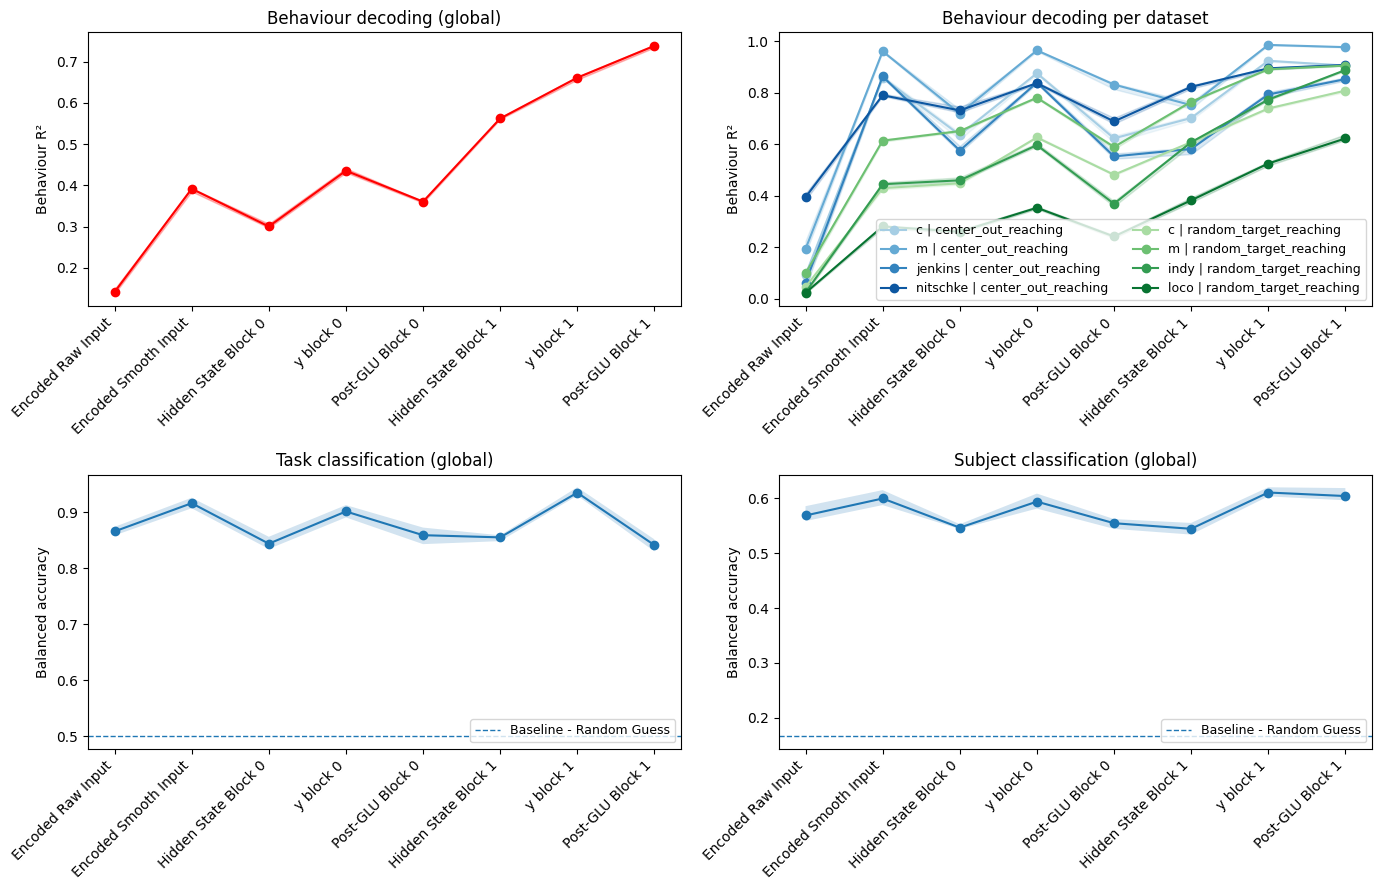

In [6]:
from neuralencoder.decoding import plot_results_grid

LABELS_2BLOCK = ['Encoded Raw Input', 'Encoded Smooth Input',
                 "Hidden State Block 0", "y block 0", "Post-GLU Block 0",
                 "Hidden State Block 1", "y block 1", "Post-GLU Block 1",
                 ]

LABELS_4BLOCK =  LABELS_2BLOCK + ["Hidden State Block 2", "y block 2", "Post-GLU Block 2",
                 "Hidden State Block 3", "y block 3", "Post-GLU Block 3",
                 ]

plot_results_grid(foundational_2block_decoding_res_loaded, LABELS_2BLOCK, 1/6, 0.5)
#plot_results_grid(foundational_2block_decoding_res, ["Post-GLU Block 1"], 1/6, 0.5)
#plot_results_grid_behaviour(foundational_2block_decoding_res_loaded, LABELS_2BLOCK, save_path='/content/drive/MyDrive/Thesis/reaching_2block_decoding.pdf')
#plot_results_grid_behaviour(foundational_4block_decoding_res_loaded, LABELS_4BLOCK, save_path='/content/drive/MyDrive/Thesis/reaching_4block_decoding.pdf')

In [ ]:
foundational_4block_decoding_res_1 = evaluate_feature_sets_pipeline(
    datasets=foundational_4block_data,
    x_keys=["post_encoder_raw", "post_encoder", "ssm_x_0", "ssm_y_0", "ssm_post_glu_0", "ssm_x_1", "ssm_y_1", "ssm_post_glu_1"],
    behaviour_key="targets",
    random_states=list(range(10)),  # e.g. 10 seeds
    test_size=0.2,
    alphas=(1e-3, 1e-2, 1e-1, 1.0),
    n_boot=5000,
    ci=95.0,
    centre="median",
    make_plots=False
)

In [ ]:
foundational_4block_decoding_res_2 = evaluate_feature_sets_pipeline(
    datasets=foundational_4block_data,
    x_keys=["ssm_x_2", "ssm_y_2", "ssm_post_glu_2", "ssm_x_3", "ssm_y_3", "ssm_post_glu_3"],
    behaviour_key="targets",
    random_states=list(range(10)),  # e.g. 10 seeds
    test_size=0.2,
    alphas=(1e-3, 1e-2, 1e-1, 1.0),
    n_boot=5000,
    ci=95.0,
    centre="median",
    make_plots=False
)

In [ ]:
from neuralencoder.decoding import merge_results

combined = merge_results(foundational_4block_decoding_res_1, foundational_4block_decoding_res_2, allow_overlap=False, order="a_then_b")
save_decoding_results(combined, "/content/drive/MyDrive/Thesis/data/reaching_4block_decoding_res_2.pkl.gz")
foundational_4block_decoding_res_loaded = load_decoding_results("/content/drive/MyDrive/Thesis/data/reaching_4block_decoding_res_2.pkl.gz")
import pickle, gzip; assert pickle.dumps(combined) == pickle.dumps(foundational_4block_decoding_res_loaded)

In [ ]:
foundational_4block_decoding_res_loaded = load_decoding_results("/content/drive/MyDrive/Thesis/data/reaching_4block_decoding_res_2.pkl.gz")

(<Figure size 1400x900 with 4 Axes>,
 array([[<Axes: title={'center': 'Behaviour decoding (global)'}, ylabel='Behaviour R²'>,
         <Axes: title={'center': 'Behaviour decoding per dataset'}, ylabel='Behaviour R²'>],
        [<Axes: title={'center': 'Task classification (global)'}, ylabel='Balanced accuracy'>,
         <Axes: title={'center': 'Subject classification (global)'}, ylabel='Balanced accuracy'>]],
       dtype=object))

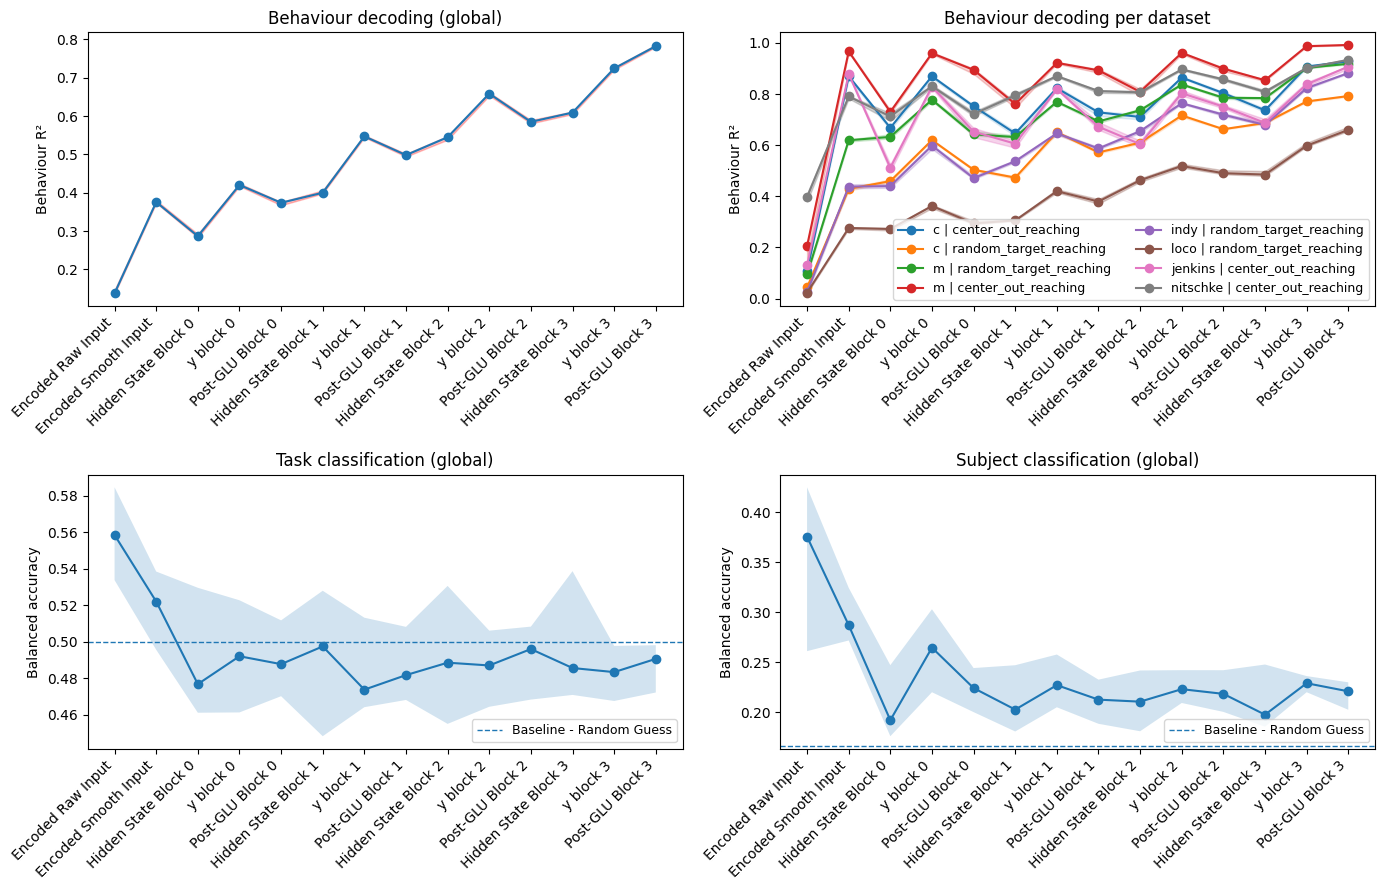

In [ ]:
LABELS_2BLOCK = ['Encoded Raw Input', 'Encoded Smooth Input',
                 "Hidden State Block 0", "y block 0", "Post-GLU Block 0",
                 "Hidden State Block 1", "y block 1", "Post-GLU Block 1",
                 ]

LABELS_4BLOCK =  LABELS_2BLOCK + ["Hidden State Block 2", "y block 2", "Post-GLU Block 2",
                 "Hidden State Block 3", "y block 3", "Post-GLU Block 3",
                 ]

plot_results_grid(foundational_4block_decoding_res_loaded, LABELS_4BLOCK, 1/6, 0.5)

## Decoding RTT

In [ ]:
from neuralencoder.decoding import evaluate_single_group_pipeline_rtt

rtt_2block_decoding_res = evaluate_single_group_pipeline_rtt(
      datasets=rtt_2block_data,
      x_keys=["post_encoder_raw", "post_encoder", "ssm_x_0", "ssm_y_0", "ssm_post_glu_0", "ssm_x_1", "ssm_y_1", "ssm_post_glu_1"],
      behaviour_key="targets",
      random_states=list(range(10)),  # e.g. 10 seeds
      test_size=0.2,
      alphas=(1e-3, 1e-2, 1e-1, 1.0),
      n_boot=5000,
      ci=95.0,
      centre="median",
)

100%|██████████| 8/8 [06:38<00:00, 49.84s/it]


In [ ]:
save_decoding_results(rtt_2block_decoding_res, "/content/drive/MyDrive/Thesis/data/rtt_2block_decoding_res_4.pkl.gz")
rtt_2block_decoding_res_loaded = load_decoding_results("/content/drive/MyDrive/Thesis/data/rtt_2block_decoding_res_4.pkl.gz")
import pickle, gzip; assert pickle.dumps(rtt_2block_decoding_res) == pickle.dumps(rtt_2block_decoding_res_loaded)

In [ ]:
rtt_4block_decoding_res = evaluate_single_group_pipeline_rtt(
      datasets=rtt_4block_data,
      x_keys=["post_encoder_raw", "post_encoder", "ssm_x_0", "ssm_y_0", "ssm_post_glu_0", "ssm_x_1", "ssm_y_1", "ssm_post_glu_1", "ssm_x_2", "ssm_y_2", "ssm_post_glu_2", "ssm_x_3", "ssm_y_3", "ssm_post_glu_3"],
      behaviour_key="targets",
      random_states=list(range(10)),  # e.g. 10 seeds
      test_size=0.2,
      alphas=(1e-3, 1e-2, 1e-1, 1.0),
      n_boot=5000,
      ci=95.0,
      centre="median",
)

100%|██████████| 14/14 [28:12<00:00, 120.89s/it]


In [ ]:
save_decoding_results(rtt_4block_decoding_res, "/content/drive/MyDrive/Thesis/data/rtt_4block_decoding_res_1.pkl.gz")
rtt_4block_decoding_res_loaded = load_decoding_results("/content/drive/MyDrive/Thesis/data/rtt_4block_decoding_res_1.pkl.gz")
import pickle, gzip; assert pickle.dumps(rtt_4block_decoding_res) == pickle.dumps(rtt_4block_decoding_res_loaded)

(<Figure size 700x450 with 1 Axes>,
 <Axes: title={'center': 'Behaviour decoding'}, ylabel='Behaviour R²'>)

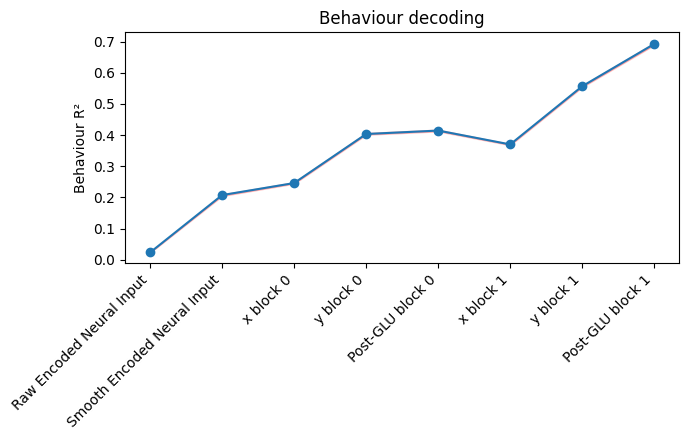

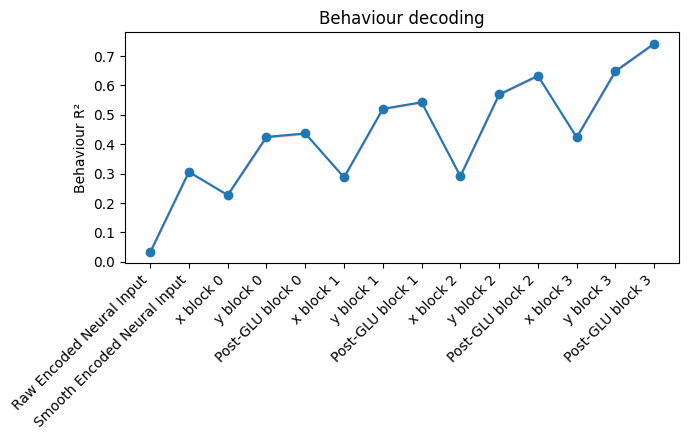

In [ ]:
from neuralencoder.decoding import plot_single_group_decoding_rtt

LABELS_2BLOCK = ['Raw Encoded Neural Input', 'Smooth Encoded Neural Input',
                 "x block 0", "y block 0", "Post-GLU block 0",
                 "x block 1", "y block 1", "Post-GLU block 1",
                 ]

LABELS_4BLOCK =  LABELS_2BLOCK + ["x block 2", "y block 2", "Post-GLU block 2",
                 "x block 3", "y block 3", "Post-GLU block 3",
                 ]

plot_single_group_decoding_rtt(rtt_2block_decoding_res_loaded, LABELS_2BLOCK)
plot_single_group_decoding_rtt(rtt_4block_decoding_res_loaded, LABELS_4BLOCK)